In [1]:
from multiprocessing import Pool
from multiprocessing import cpu_count

import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm

from dataset import SyntheticRankingBanditDataset
from ope.estimator import InversePropensityScore as IPS
from ope.estimator_tuning import UserBehaviorTree
from ope.importance_weight import vanilla_weight, independent_weight, cascade_weight, adaptive_weight, neighbor_k_weight, inverse_cascade_weight
from ope.meta import RankingOffPolicyEvaluation
from utils.util import aggregate_simulation_results, visualize_mean_squared_error
from utils.policy import gen_eps_greedy

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def simulate_evaluation(args):
    ope_estimators, ope_estimators_tune, dataset, val_size, eps = args
    # generate synthetic data
    val_data = dataset.obtain_batch_bandit_feedback(n_rounds=val_size)
        
    # evaluation policy
    evaluation_policy = gen_eps_greedy(expected_reward=val_data["evaluation_policy_logit"], eps=eps)
        
    # off policy evaluation
    ope = RankingOffPolicyEvaluation(
        bandit_feedback=val_data,
        ope_estimators=ope_estimators,
        ope_estimators_tune=ope_estimators_tune
    )
    estimated_policy_values = ope.estimate_policy_values(action_dist=evaluation_policy)
    
    return estimated_policy_values

In [3]:
# setting 1

# 変数
# key: added behavior, value: complexity
behavior_complexity = {"independent": 0.0, "cascade": 0.2, "top_2_cascade": 0.4, "neighbor_4": 0.6, "inverse_cascade": 0.8, "standard": 1.0}

# 定数
test_size=100000
n_sim=1000
dim_context=3
len_list=7
n_actions_at_k=2
val_size=1000
beta=-1
eps=0.3
random_state=12345
ope_estimators=[IPS(estimator_name="AIPS (true)"), IPS(estimator_name="RIPS"), IPS(estimator_name="IIPS"), IPS(estimator_name="SIPS")]
interaction_noise=4.0

# tuning setting of the user behavior
param_name="estimated_user_behavior"
bias_estimation_method="experimental_on_policy"
weight_func=adaptive_weight
candidate_models={"independent": independent_weight, "cascade": cascade_weight, "neighbor_4": neighbor_k_weight, "inverse_cascade": inverse_cascade_weight}
val_size_bias_estimation=10000
n_partition=5
min_samples_leaf=100
n_bootstrap=10
max_depth=5


In [4]:
# experiment-1 varying complexity of the user behavior

# init
behavior_params = dict()

result_df_list = []
for behavior_name, complexity in behavior_complexity.items():
    behavior_params[behavior_name] = 1.0
    
    dataset = SyntheticRankingBanditDataset(
        n_actions_at_k=n_actions_at_k,
        len_list=len_list,
        dim_context=dim_context,
        behavior_params=behavior_params,
        beta=beta,
        eps=eps,
        random_state=random_state,
        interaction_noise=interaction_noise
    )
    ope_estimators_tune = [
        UserBehaviorTree(
            estimator=IPS(estimator_name="AIPS - tree"),
            param_name=param_name,
            bias_estimation_method=bias_estimation_method,
            dataset=dataset,
            weight_func=weight_func,
            candidate_models=candidate_models,
            eps=eps,
            val_size=val_size_bias_estimation,
            len_list=len_list,
            n_partition=n_partition,
            min_samples_leaf=min_samples_leaf,
            n_bootstrap=n_bootstrap,
            max_depth=max_depth
        )
    ]

    # calculate ground truth policy value
    test_data = dataset.obtain_batch_bandit_feedback(n_rounds=test_size, is_online=True)
    policy_value = test_data["expected_reward_factual"].sum(1).mean()
    
    
    job_args = [(ope_estimators, ope_estimators_tune, dataset, val_size, eps) for _ in range(n_sim)]
    with Pool(cpu_count()-1) as pool:
        imap_iter = pool.imap(simulate_evaluation, job_args)
        tqdm_ = tqdm(imap_iter, total=n_sim, desc=f"behavior_complexity={complexity}, included user behavior={list(behavior_params.keys())}...")
        result_list = list(tqdm_)
    
    # calculate MSE
    result_df = aggregate_simulation_results(
        simulation_result_list=result_list,
        policy_value=policy_value,
        x_value=complexity
    )
    result_df_list.append(result_df)
        
result_df = pd.concat(result_df_list).reset_index(level=0)

behavior_complexity=0.0, included user behavior=['independent']...: 100% 1000/1000 [02:26<00:00,  6.81it/s]
behavior_complexity=0.2, included user behavior=['independent', 'cascade']...: 100% 1000/1000 [01:44<00:00,  9.58it/s]
behavior_complexity=0.4, included user behavior=['independent', 'cascade', 'top_2_cascade']...: 100% 1000/1000 [01:53<00:00,  8.78it/s]
behavior_complexity=0.6, included user behavior=['independent', 'cascade', 'top_2_cascade', 'neighbor_4']...: 100% 1000/1000 [01:43<00:00,  9.68it/s]
behavior_complexity=0.8, included user behavior=['independent', 'cascade', 'top_2_cascade', 'neighbor_4', 'inverse_cascade']...: 100% 1000/1000 [01:39<00:00, 10.07it/s]
behavior_complexity=1.0, included user behavior=['independent', 'cascade', 'top_2_cascade', 'neighbor_4', 'inverse_cascade', 'standard']...: 100% 1000/1000 [01:37<00:00, 10.23it/s]


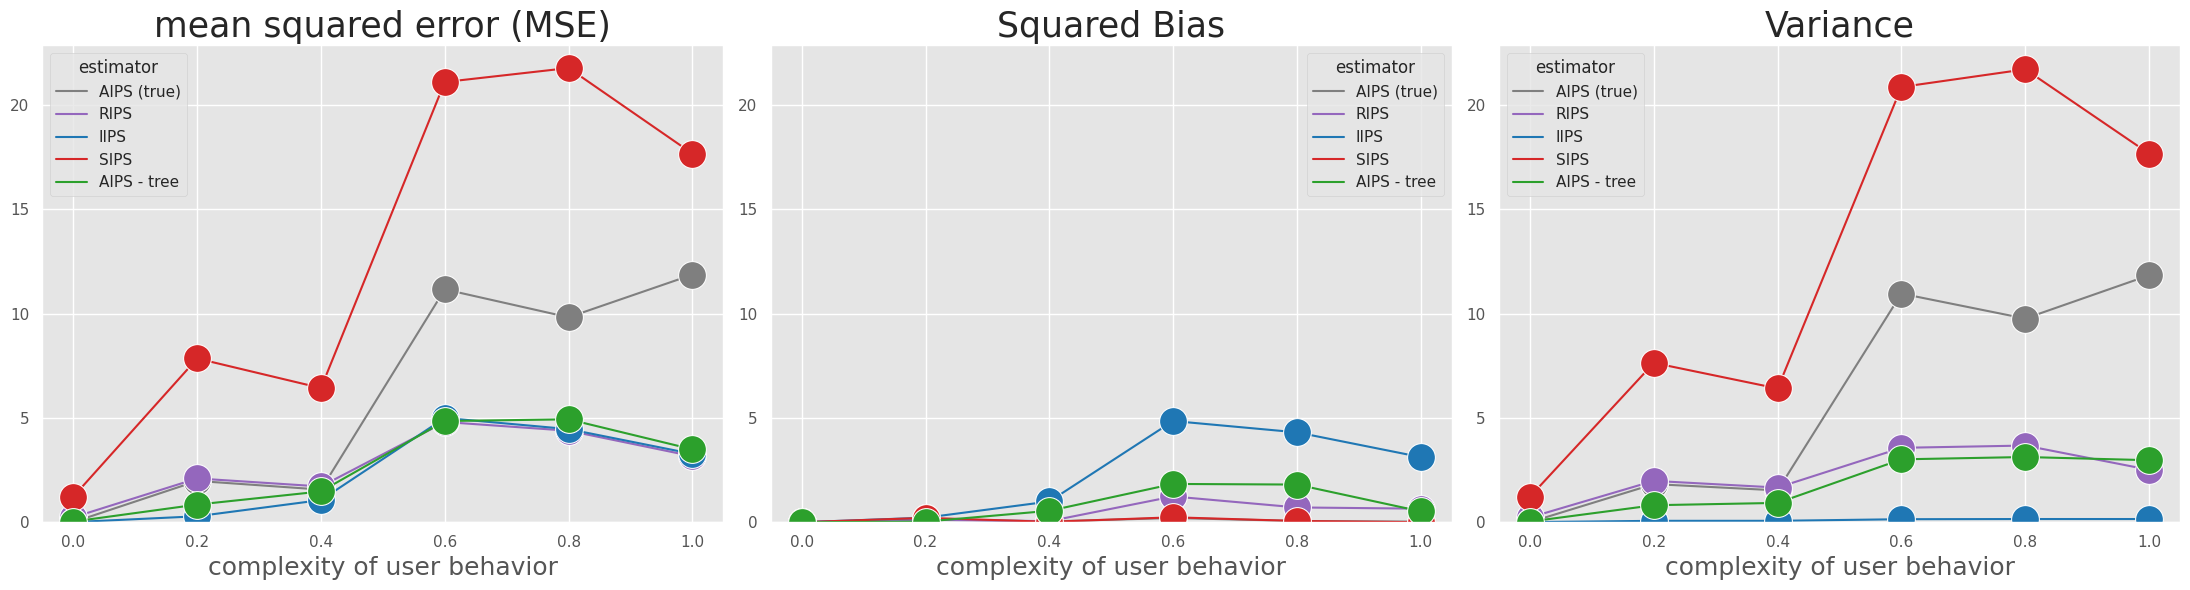

In [6]:
visualize_mean_squared_error(result_df=result_df, xlabel="complexity of user behavior")